In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mpld3

mpld3.enable_notebook()

/Users/vpetit/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/vpetit/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


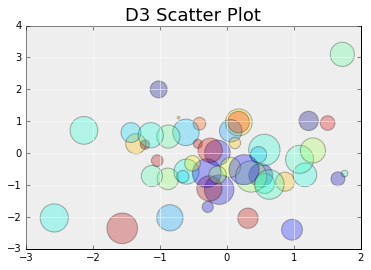

In [2]:
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
ax.grid(color='white', linestyle='solid')

N = 50
scatter = ax.scatter(np.random.normal(size=N),
                     np.random.normal(size=N),
                     c=np.random.random(size=N),
                     s = 1000 * np.random.random(size=N),
                     alpha=0.3,
                     cmap=plt.cm.jet)

ax.set_title("D3 Scatter Plot", size=18);

In [7]:
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
N = 100

scatter = ax.scatter(np.random.normal(size=N),
                     np.random.normal(size=N),
                     c=np.random.random(size=N),
                     s=1000 * np.random.random(size=N),
                     alpha=0.3,
                     cmap=plt.cm.jet)
ax.grid(color='white', linestyle='solid')

ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = ['point {0}'.format(i + 1) for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import mpld3
from mpld3 import plugins, utils


class LinkedView(plugins.PluginBase):
    """A simple plugin showing how multiple axes can be linked"""

    JAVASCRIPT = """
    mpld3.register_plugin("linkedview", LinkedViewPlugin);
    LinkedViewPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    LinkedViewPlugin.prototype.constructor = LinkedViewPlugin;
    LinkedViewPlugin.prototype.requiredProps = ["idpts", "idline", "data"];
    LinkedViewPlugin.prototype.defaultProps = {}
    function LinkedViewPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    LinkedViewPlugin.prototype.draw = function(){
      var pts = mpld3.get_element(this.props.idpts);
      var line = mpld3.get_element(this.props.idline);
      var data = this.props.data;

      function mouseover(d, i){
        line.data = data[i];
        line.elements().transition()
            .attr("d", line.datafunc(line.data))
            .style("stroke", this.style.fill);
      }
      pts.elements().on("mouseover", mouseover);
    };
    """

    def __init__(self, points, line, linedata):
        if isinstance(points, matplotlib.lines.Line2D):
            suffix = "pts"
        else:
            suffix = None

        self.dict_ = {"type": "linkedview",
                      "idpts": utils.get_id(points, suffix),
                      "idline": utils.get_id(line),
                      "data": linedata}

In [5]:
fig, ax = plt.subplots(2)

# scatter periods and amplitudes
np.random.seed(0)
P = 0.2 + np.random.random(size=20)
A = np.random.random(size=20)
x = np.linspace(0, 10, 100)
data = np.array([[x, Ai * np.sin(x / Pi)]
                 for (Ai, Pi) in zip(A, P)])
points = ax[1].scatter(P, A, c=P + A,
                       s=200, alpha=0.5)
ax[1].set_xlabel('Period')
ax[1].set_ylabel('Amplitude')

# create the line object
lines = ax[0].plot(x, 0 * x, '-w', lw=3, alpha=0.5)
ax[0].set_ylim(-1, 1)

ax[0].set_title("Hover over points to see lines")

# transpose line data and add plugin
linedata = data.transpose(0, 2, 1).tolist()
plugins.connect(fig, LinkedView(points, lines[0], linedata))

mpld3.display()

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import mpld3
from mpld3 import plugins

fig, ax = plt.subplots()

x = np.linspace(-2, 2, 20)
y = x[:, None]
X = np.zeros((20, 20, 4))

X[:, :, 0] = np.exp(- (x - 1) ** 2 - (y) ** 2)
X[:, :, 1] = np.exp(- (x + 0.71) ** 2 - (y - 0.71) ** 2)
X[:, :, 2] = np.exp(- (x + 0.71) ** 2 - (y + 0.71) ** 2)
X[:, :, 3] = np.exp(-0.25 * (x ** 2 + y ** 2))

im = ax.imshow(X, extent=(10, 20, 10, 20),
               origin='lower', zorder=1, interpolation='nearest')
fig.colorbar(im, ax=ax)

ax.set_title('An Image', size=20)

plugins.connect(fig, plugins.MousePosition(fontsize=14))

mpld3.display()

In [9]:
import jinja2
import json
import numpy as np
import matplotlib.pyplot as plt

import mpld3
from mpld3 import plugins, utils


class HighlightLines(plugins.PluginBase):
    """A plugin to highlight lines on hover"""

    JAVASCRIPT = """
    mpld3.register_plugin("linehighlight", LineHighlightPlugin);
    LineHighlightPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    LineHighlightPlugin.prototype.constructor = LineHighlightPlugin;
    LineHighlightPlugin.prototype.requiredProps = ["line_ids"];
    LineHighlightPlugin.prototype.defaultProps = {alpha_bg:0.3, alpha_fg:1.0}
    function LineHighlightPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    LineHighlightPlugin.prototype.draw = function(){
      for(var i=0; i<this.props.line_ids.length; i++){
         var obj = mpld3.get_element(this.props.line_ids[i], this.fig),
             alpha_fg = this.props.alpha_fg;
             alpha_bg = this.props.alpha_bg;
         obj.elements()
             .on("mouseover", function(d, i){
                            d3.select(this).transition().duration(50)
                              .style("stroke-opacity", alpha_fg); })
             .on("mouseout", function(d, i){
                            d3.select(this).transition().duration(200)
                              .style("stroke-opacity", alpha_bg); });
      }
    };
    """

    def __init__(self, lines):
        self.lines = lines
        self.dict_ = {"type": "linehighlight",
                      "line_ids": [utils.get_id(line) for line in lines],
                      "alpha_bg": lines[0].get_alpha(),
                      "alpha_fg": 1.0}


N_paths = 50
N_steps = 100

x = np.linspace(0, 10, 100)
y = 0.1 * (np.random.random((N_paths, N_steps)) - 0.5)
y = y.cumsum(1)

fig, ax = plt.subplots(subplot_kw={'xticks': [], 'yticks': []})
lines = ax.plot(x, y.T, color='blue', lw=4, alpha=0.1)
plugins.connect(fig, HighlightLines(lines))

mpld3.display()